# Data Preparation

In [1]:
import pandas as pd

def aggregated_df(df, all_values_words):
    # Reformat the data: Column for each possible action and value in each cell is the number of agents performed that action
    df = df.apply(pd.value_counts, axis=1).fillna(0)
    df = df.reindex(columns=all_values_words, fill_value=0)
    return df

In [2]:
# Create a new column called "Combined Attacks" that sums the values of all columns that start with "attacks"
# Delete original columns

def combine_actions(df):
    df['Combined Attacks'] = df.filter(like='attacks').sum(axis=1)
    df = df.drop(df.filter(regex='^attacks').columns, axis=1)

    #Combine heals
    df['Combined Heals'] = df.filter(like='heals').sum(axis=1)
    df = df.drop(df.filter(regex='^heals').columns, axis=1)
    return df

In [3]:
import numpy as np 
from tslearn.utils import to_time_series_dataset
import os
from os.path import join

# TODO: Add remove dead option
def read_trajectories(dir, comb_acts=True):
    all_dfs = []
    final_dfs = []
    file_list = os.listdir(dir)

    all_actions = set()
    
    for filename in file_list:
        df = pd.read_csv(join(dir, filename), index_col=None, header=None)
        all_actions.update(df.values.flatten())
        all_dfs.append(df)

    all_actions.discard(np.nan)
    #all_actions.discard('Dead')

    all_actions = list(all_actions)
    all_actions.sort()

    for df in all_dfs:
        df = aggregated_df(df, all_actions)
        if comb_acts:
            df = combine_actions(df)
        # Percentage of agents performed each action
        df = df.div(df.sum(axis=1), axis=0)
        df = df.to_numpy()
        final_dfs.append(df)

    final_dfs = np.array(final_dfs)
    final_dfs = to_time_series_dataset(final_dfs)
    # mean_per_feature = np.nanmean(final_dfs, axis=(0, 1))
    # std_per_feature = np.nanstd(final_dfs, axis=(0, 1))
    # all_dfs_normalized = (final_dfs - mean_per_feature) / std_per_feature
    if comb_acts:
        all_actions.append("Combined Attacks")
        all_actions.append("Combined Heals")
        all_actions = [x for x in all_actions if not x.startswith('attacks') and not x.startswith('heals')]
    return final_dfs, all_actions, file_list

#Fill this:
input_dir = ""
all_dfs, cols, file_list = read_trajectories(input_dir, comb_acts=True)

C:\Users\User\AppData\Local\Temp\ipykernel_37968\1518015851.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_dfs = np.array(final_dfs)


### Trajectory as Time Series Example

In [4]:
import matplotlib.pyplot as plt

def show_trajectory_time_series(trajectory, rows_num, cols_num, cols, output_file):
    fig, axs = plt.subplots(rows_num, cols_num, figsize=(15, 10), sharey=True)

    for i, feature in enumerate(cols):
        # Draw the trajectory feature as time series
        axs[i // cols_num][i % cols_num].plot(trajectory.T[i], label="Trajectory")
        axs[i // cols_num][i % cols_num].set_title(feature)
        axs[i // cols_num][i % cols_num].set_xlabel("Step")
        axs[i // cols_num][i % cols_num].set_ylabel("% of Agents")

    fig.suptitle("Example Time Series (Trajectory)", fontsize=16)
    plt.subplots_adjust(bottom=0.15)  # Adjust the bottom margin


    plt.tight_layout()
    plt.savefig(output_file)

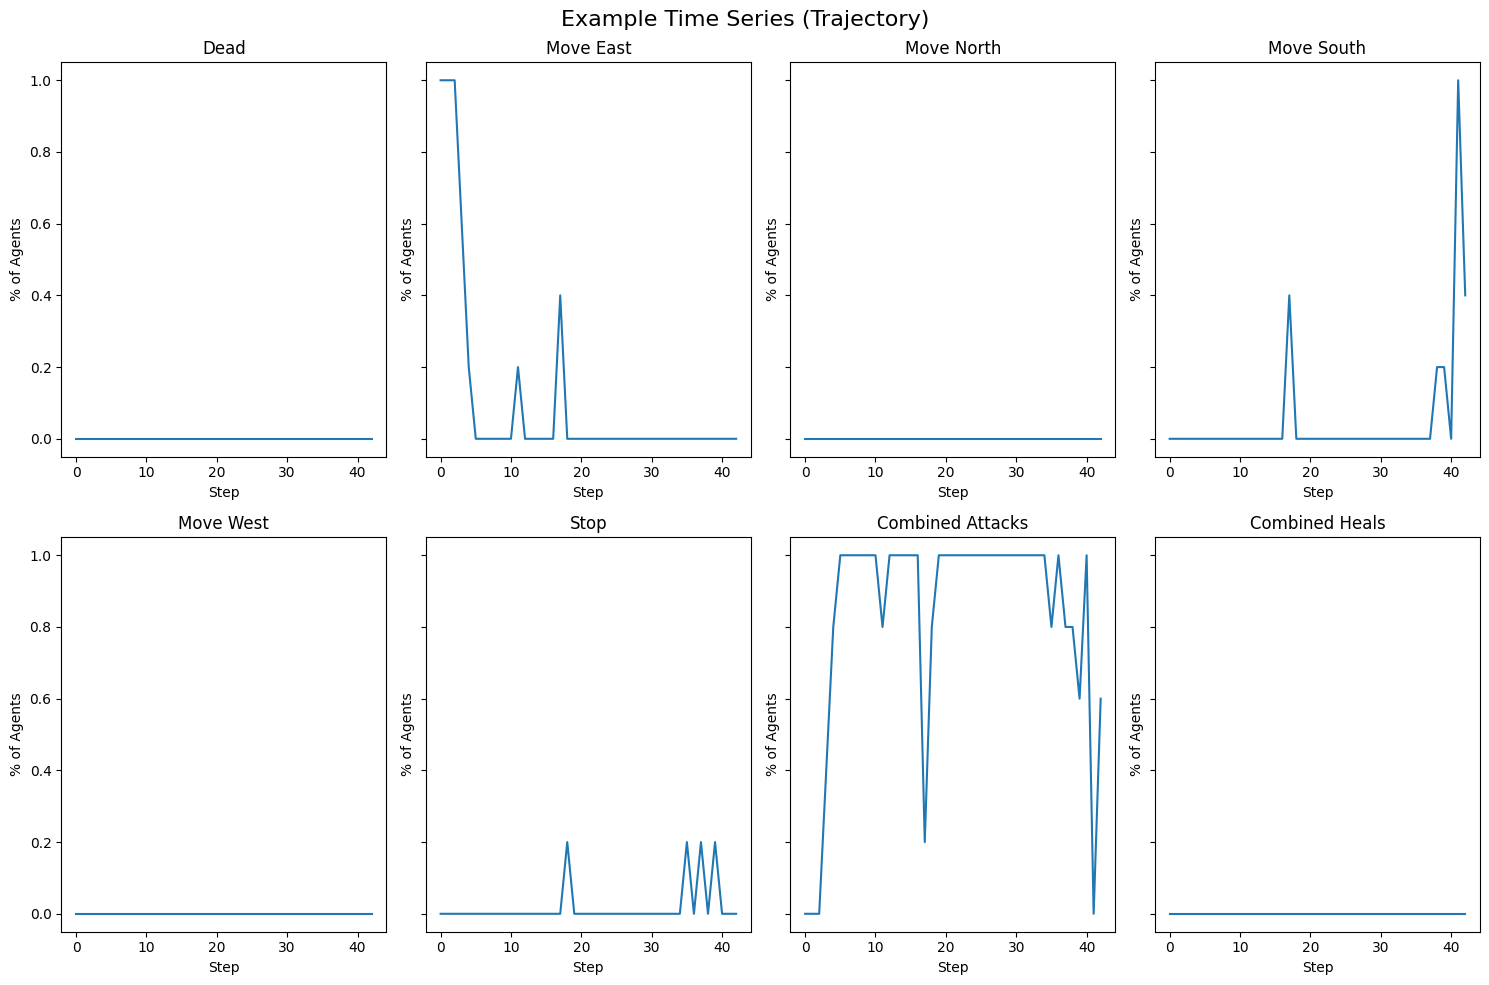

In [5]:
show_trajectory_time_series(all_dfs[0], 2, 4, cols, "trajectory_example.png")

### Clustering Example - 2 Scenarios

In [15]:
from tslearn.clustering import TimeSeriesKMeans

def run_time_series_k_means(df, k):
    km = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=42, max_iter=50, n_init=10)
    cluster_labels = km.fit_predict(df)
    return km, cluster_labels

In [7]:
example_two_scenarios, two_scenarios_labels = run_time_series_k_means(all_dfs[:50], 2)
two_scenarios_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [8]:
import matplotlib.pyplot as plt


def show_cluster_centers(km_clusters, rows_num, cols_num, cols, output_file):
    # Create a subplot for each feature
    fig, axs = plt.subplots(rows_num, cols_num, figsize=(15, 10), sharey=True)
    for i, feature in enumerate(cols):
        for clus in km_clusters.cluster_centers_:
            axs[i // cols_num][i % cols_num].plot(clus.T[i], label="Cluster" + str(i))
            axs[i // cols_num][i % cols_num].set_title(feature)
            axs[i // cols_num][i % cols_num].set_xlabel("Step")
            axs[i // cols_num][i % cols_num].set_ylabel("% of Agents")

    fig.suptitle("Cluster Comparison", fontsize=16)
    handles, labels = axs[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1), ncol=2)

    plt.tight_layout()
    plt.savefig(output_file)

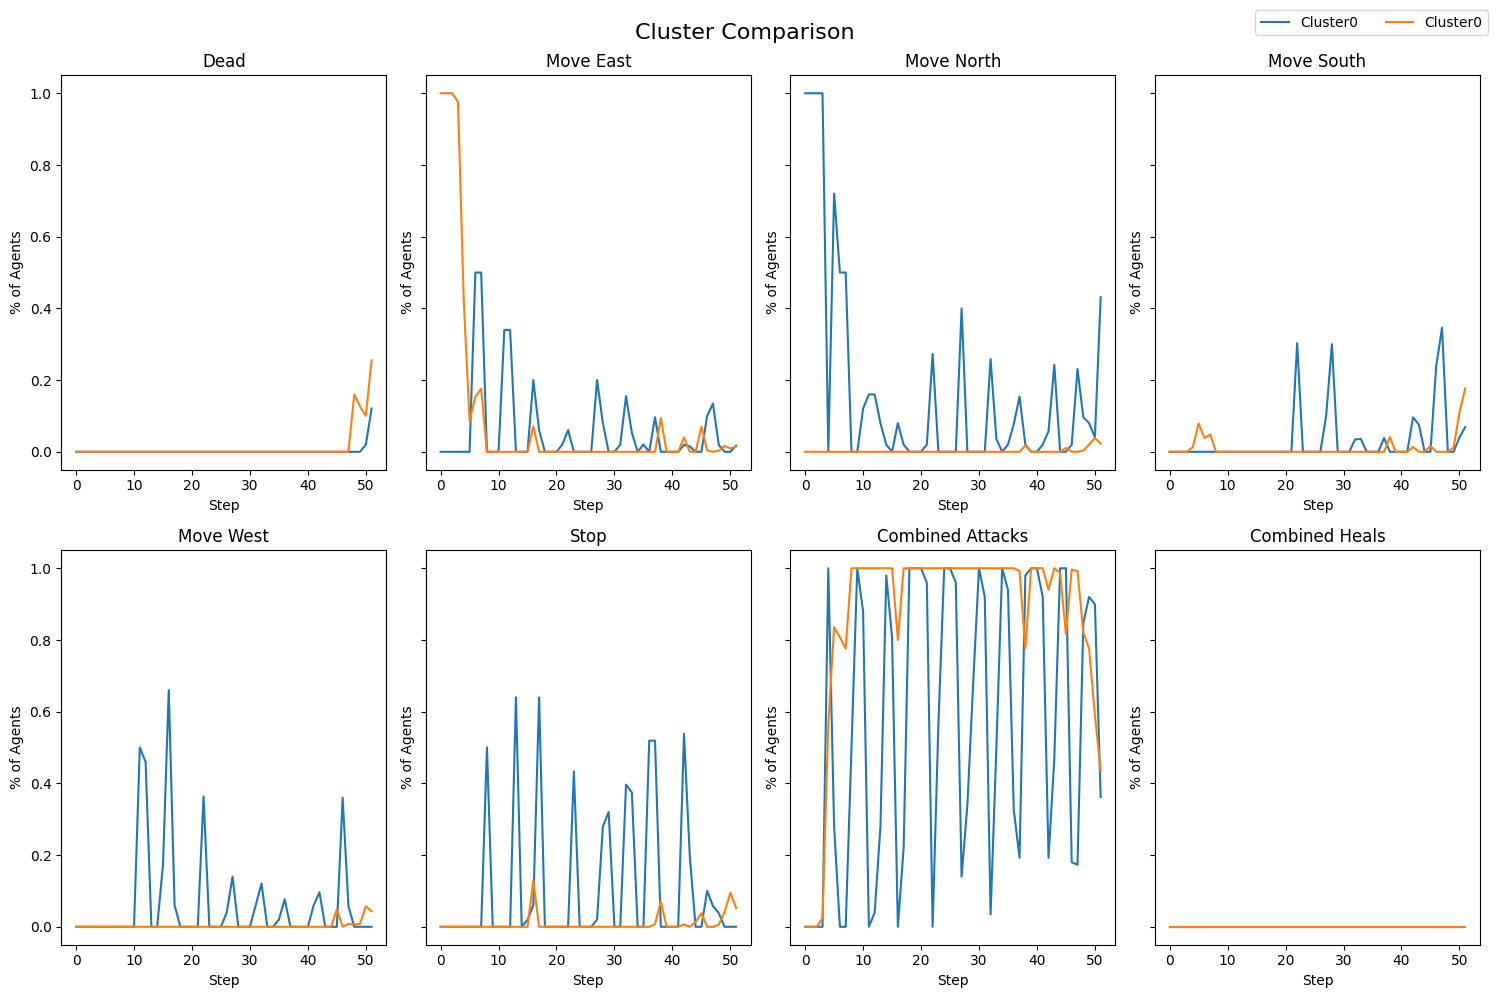

In [9]:
show_cluster_centers(example_two_scenarios, 2, 4, cols, "cluster_centers.png")

In [34]:
import matplotlib.pyplot as plt
import itertools

# A function that shows for each cluster center the main action (that was done by the largest amount of agent) for each timestep

def show_main_action_graph(km_clusters, rows_num, cols_num, cols, output_file):
    # Collect the main action from each cluster on each timestep
    final = {}
    for i, clus in enumerate(km_clusters):
        final[i] = {}
        for j, tms in enumerate(clus):
            max_value = np.max(tms)
            max_index = np.argmax(tms)
            final[i][j] = (max_index, max_value)
    
    # Make a dataframe from the dictionary
    final_df = pd.DataFrame.from_dict(final, orient="index")
    color_map = [
        '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
        '#5254a3', '#6b6ecf', '#9c9ede', '#637939', '#8ca252',
        '#b5cf6b', '#cedb9c', '#8c6d31'
    ]

    used_colors = []
    
    num_clusters = len(km_clusters)
    fig, axs = plt.subplots(rows_num, cols_num, figsize=(5*num_clusters, 3*num_clusters))   
    for i, clus in enumerate(km_clusters):
        # Extract X, colors, and Y values from the series
        x_values = range(len(final_df.loc[i]))
        colors = [item[0] for item in final_df.loc[i].values]
        y_values = [item[1] for item in final_df.loc[i].values]

        used_colors.append(np.unique(colors))

        if rows_num > 1:
            ax = axs[i // cols_num, i % cols_num]
        else:
            ax = axs[i % cols_num]

        # Plot the data
        for j in range(len(x_values) - 1):
            ax.plot([x_values[j], x_values[j+1]], [y_values[j], y_values[j+1]], color=color_map[colors[j]])

        # Set labels and title
        ax.set_xlabel("Step")
        ax.set_ylabel("% of Agents")
        ax.set_title("Cluster " + str(i))
    used_colors = set(itertools.chain.from_iterable(used_colors))

    legend_labels = [cols[color] for color in used_colors]
    handles = [plt.Line2D([], [], color=color_map[color]) for color in used_colors]

    fig.legend(handles, legend_labels, loc='center right', bbox_to_anchor=(1.2, 0.5))
    fig.subplots_adjust(right=0.85)
    fig.suptitle("Cluster Main Actions", fontsize=16)

    # Adjust the layout to accommodate the legends
    plt.tight_layout()

    # Show the plot
    plt.savefig(output_file, bbox_inches='tight')
    plt.show()

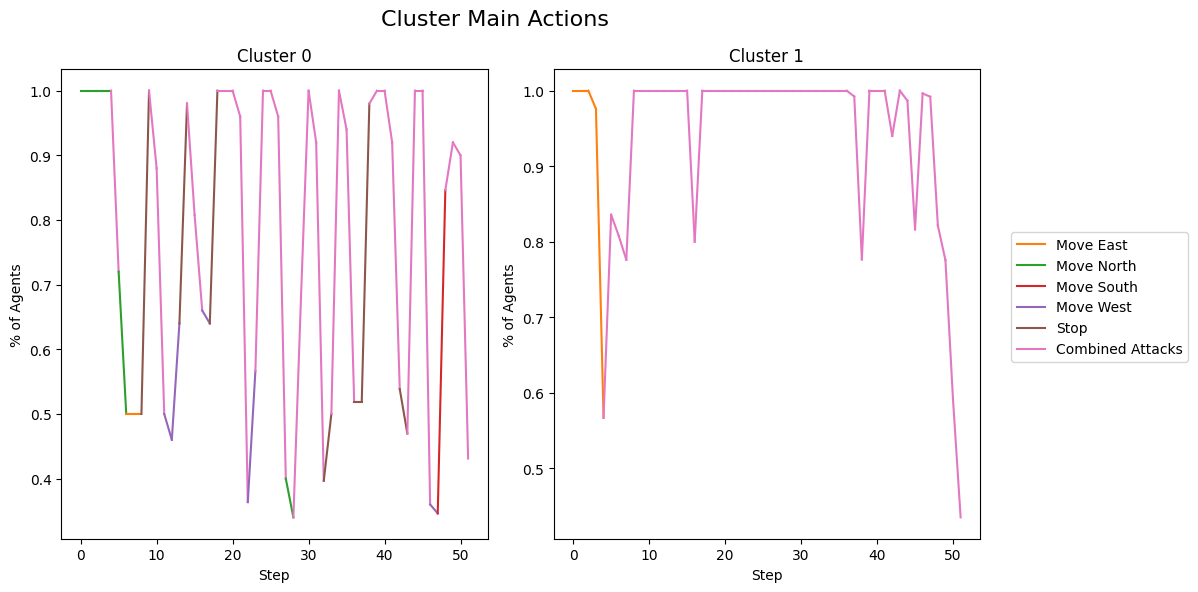

In [35]:
show_main_action_graph(example_two_scenarios.cluster_centers_, 1, 2, cols, "main_action_2_clusters.png")

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def show_stacked_action_graph(km_clusters, rows_num, cols_num, cols, output_file):

    custom_palette = sns.color_palette("Set3", n_colors=len(cols))
        
    # Create a stacked area plot for each cluster center
    num_clusters = len(km_clusters)
    fig, axs = plt.subplots(rows_num, cols_num, figsize=(5*num_clusters, 3*num_clusters), sharex=True, sharey=True)
    
    for i, cluster_center in enumerate(km_clusters):

        if rows_num > 1:
            ax = axs[i // cols_num, i % cols_num]
        else:
            ax = axs[i % cols_num]

        cluster_center = cluster_center.T
        ax.stackplot(range(len(cluster_center[0])), cluster_center, colors=custom_palette)
        ax.set_xlabel('Step')
        ax.set_ylabel('Cumulative % of Agents')
        ax.set_title(f'Cluster {i}')
    
    fig.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), labels=cols)
    fig.suptitle(f'Cluster Centers')   
    plt.tight_layout()
    plt.savefig(output_file, bbox_inches='tight')
    plt.show()

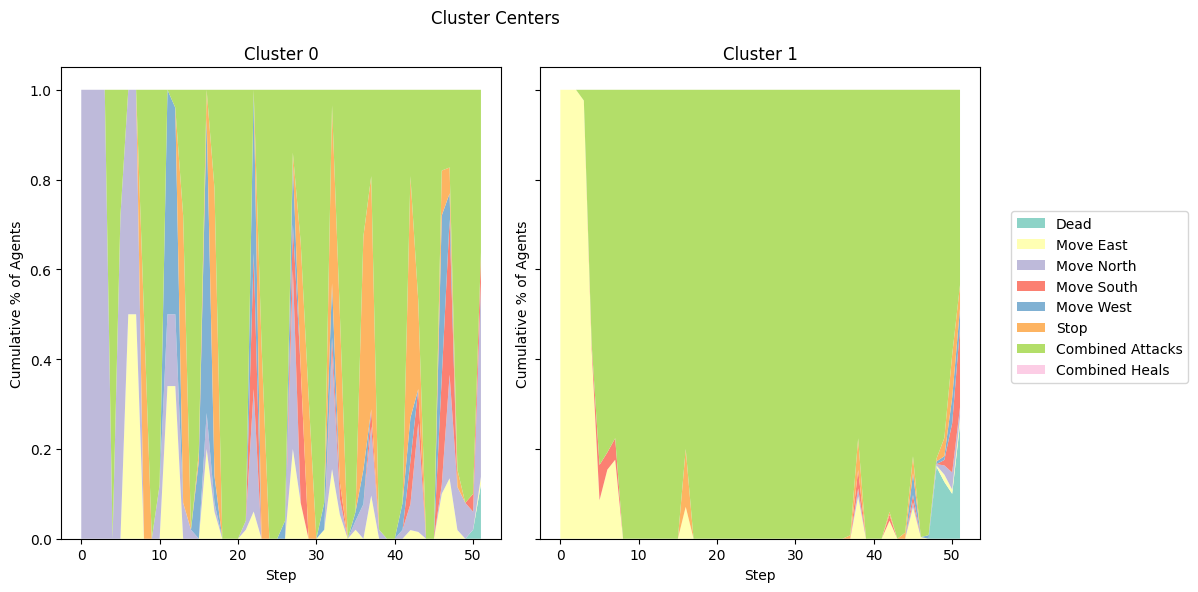

In [37]:
show_stacked_action_graph(example_two_scenarios.cluster_centers_, 1, 2, cols, "stacked_action_2_clusters.png")

### Optimal Number of Clusters ("Strategies")

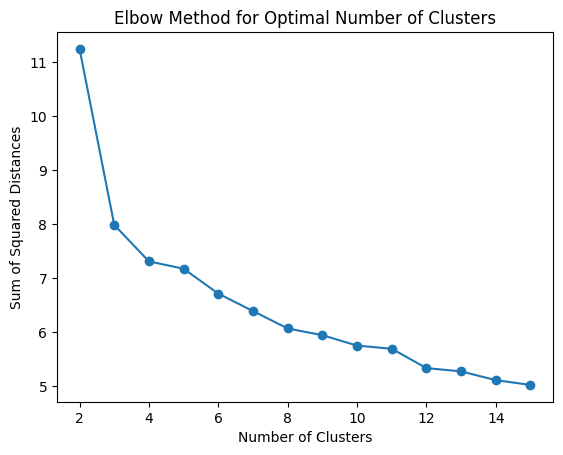

In [8]:
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt

# Find the optimal number of clusters:
clus_num = range(2,16)
ssd = []
for num in clus_num:
    km_num = TimeSeriesKMeans(n_clusters=num, metric="dtw", random_state=42)
    km_num.fit_predict(all_dfs)
    ssd.append(km_num.inertia_)

# Plot the sum of squared distances
plt.plot(clus_num, ssd, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Distances")
plt.title("Elbow Method for Optimal Number of Clusters")
plt.savefig("Optimal_Clusters_Elbow.png")
plt.show()


### Representation for Each Cluster

In [17]:
number_of_clusters = 5
km_clusters, km_clusters_labels = run_time_series_k_means(all_dfs, number_of_clusters)
km_clusters_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [18]:
# Shows what cluster each trajectory was assigned to
df = pd.DataFrame(list(zip(file_list, km_clusters_labels)), columns =['File', 'Cluster'])
df.to_csv("KMeans_{}_Clusters.csv".format(number_of_clusters), index=False)

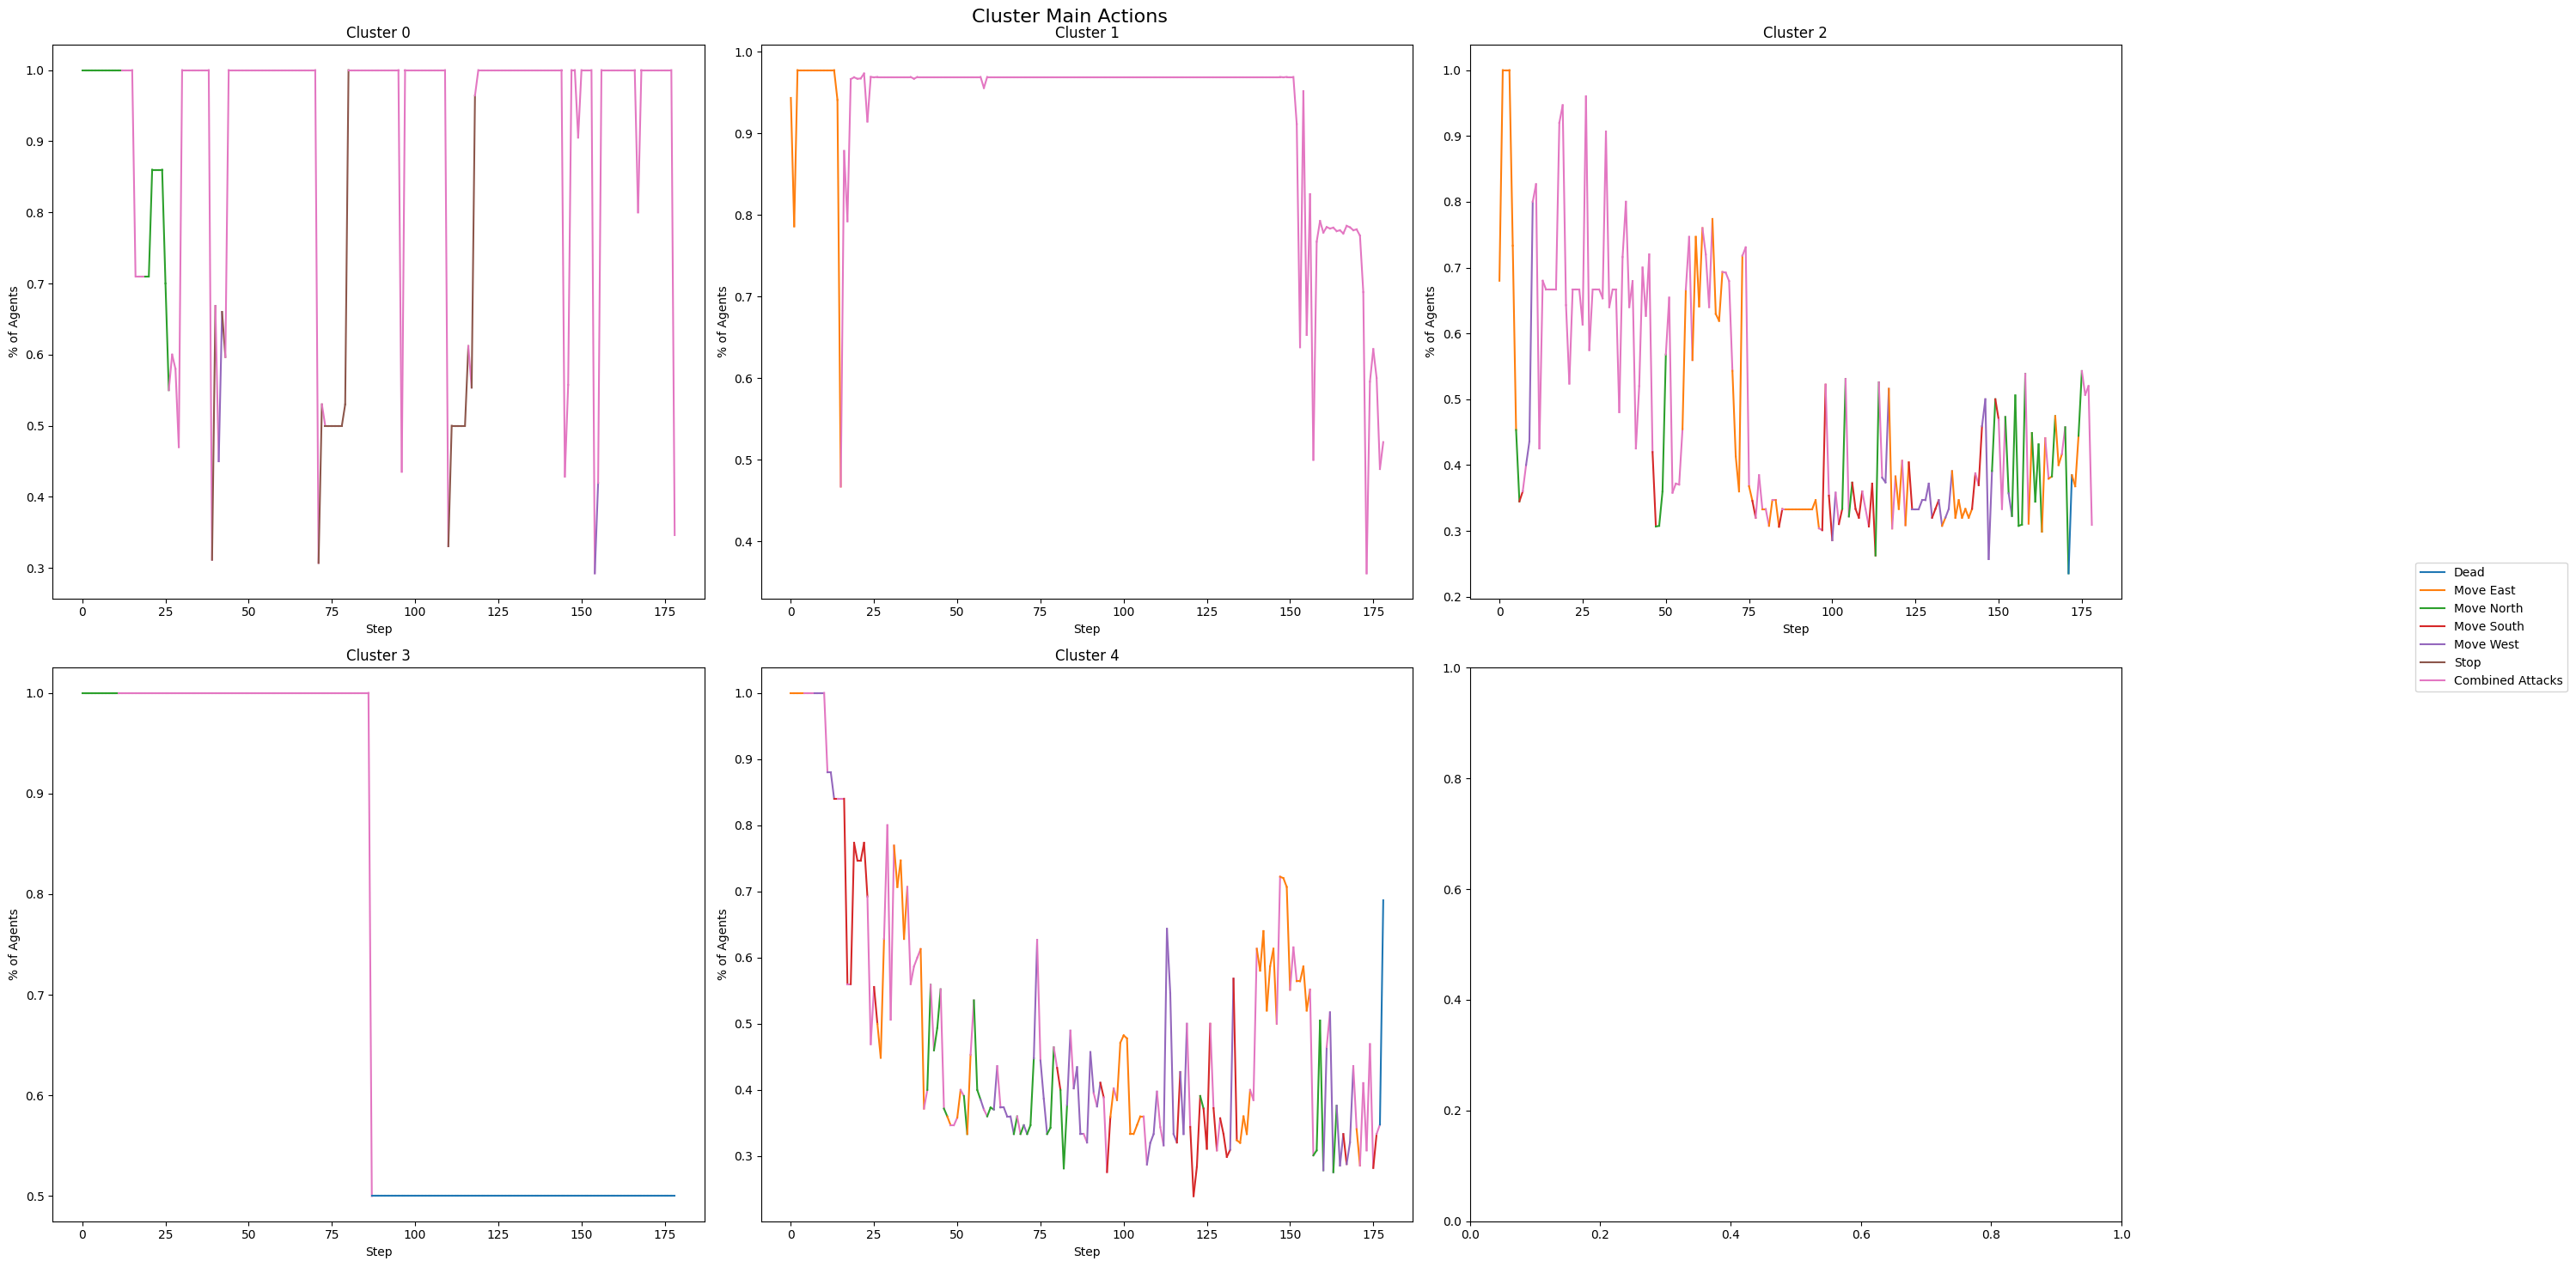

In [38]:
show_main_action_graph(km_clusters.cluster_centers_, 2, 3, cols, "all_clusters_main_actions.png")

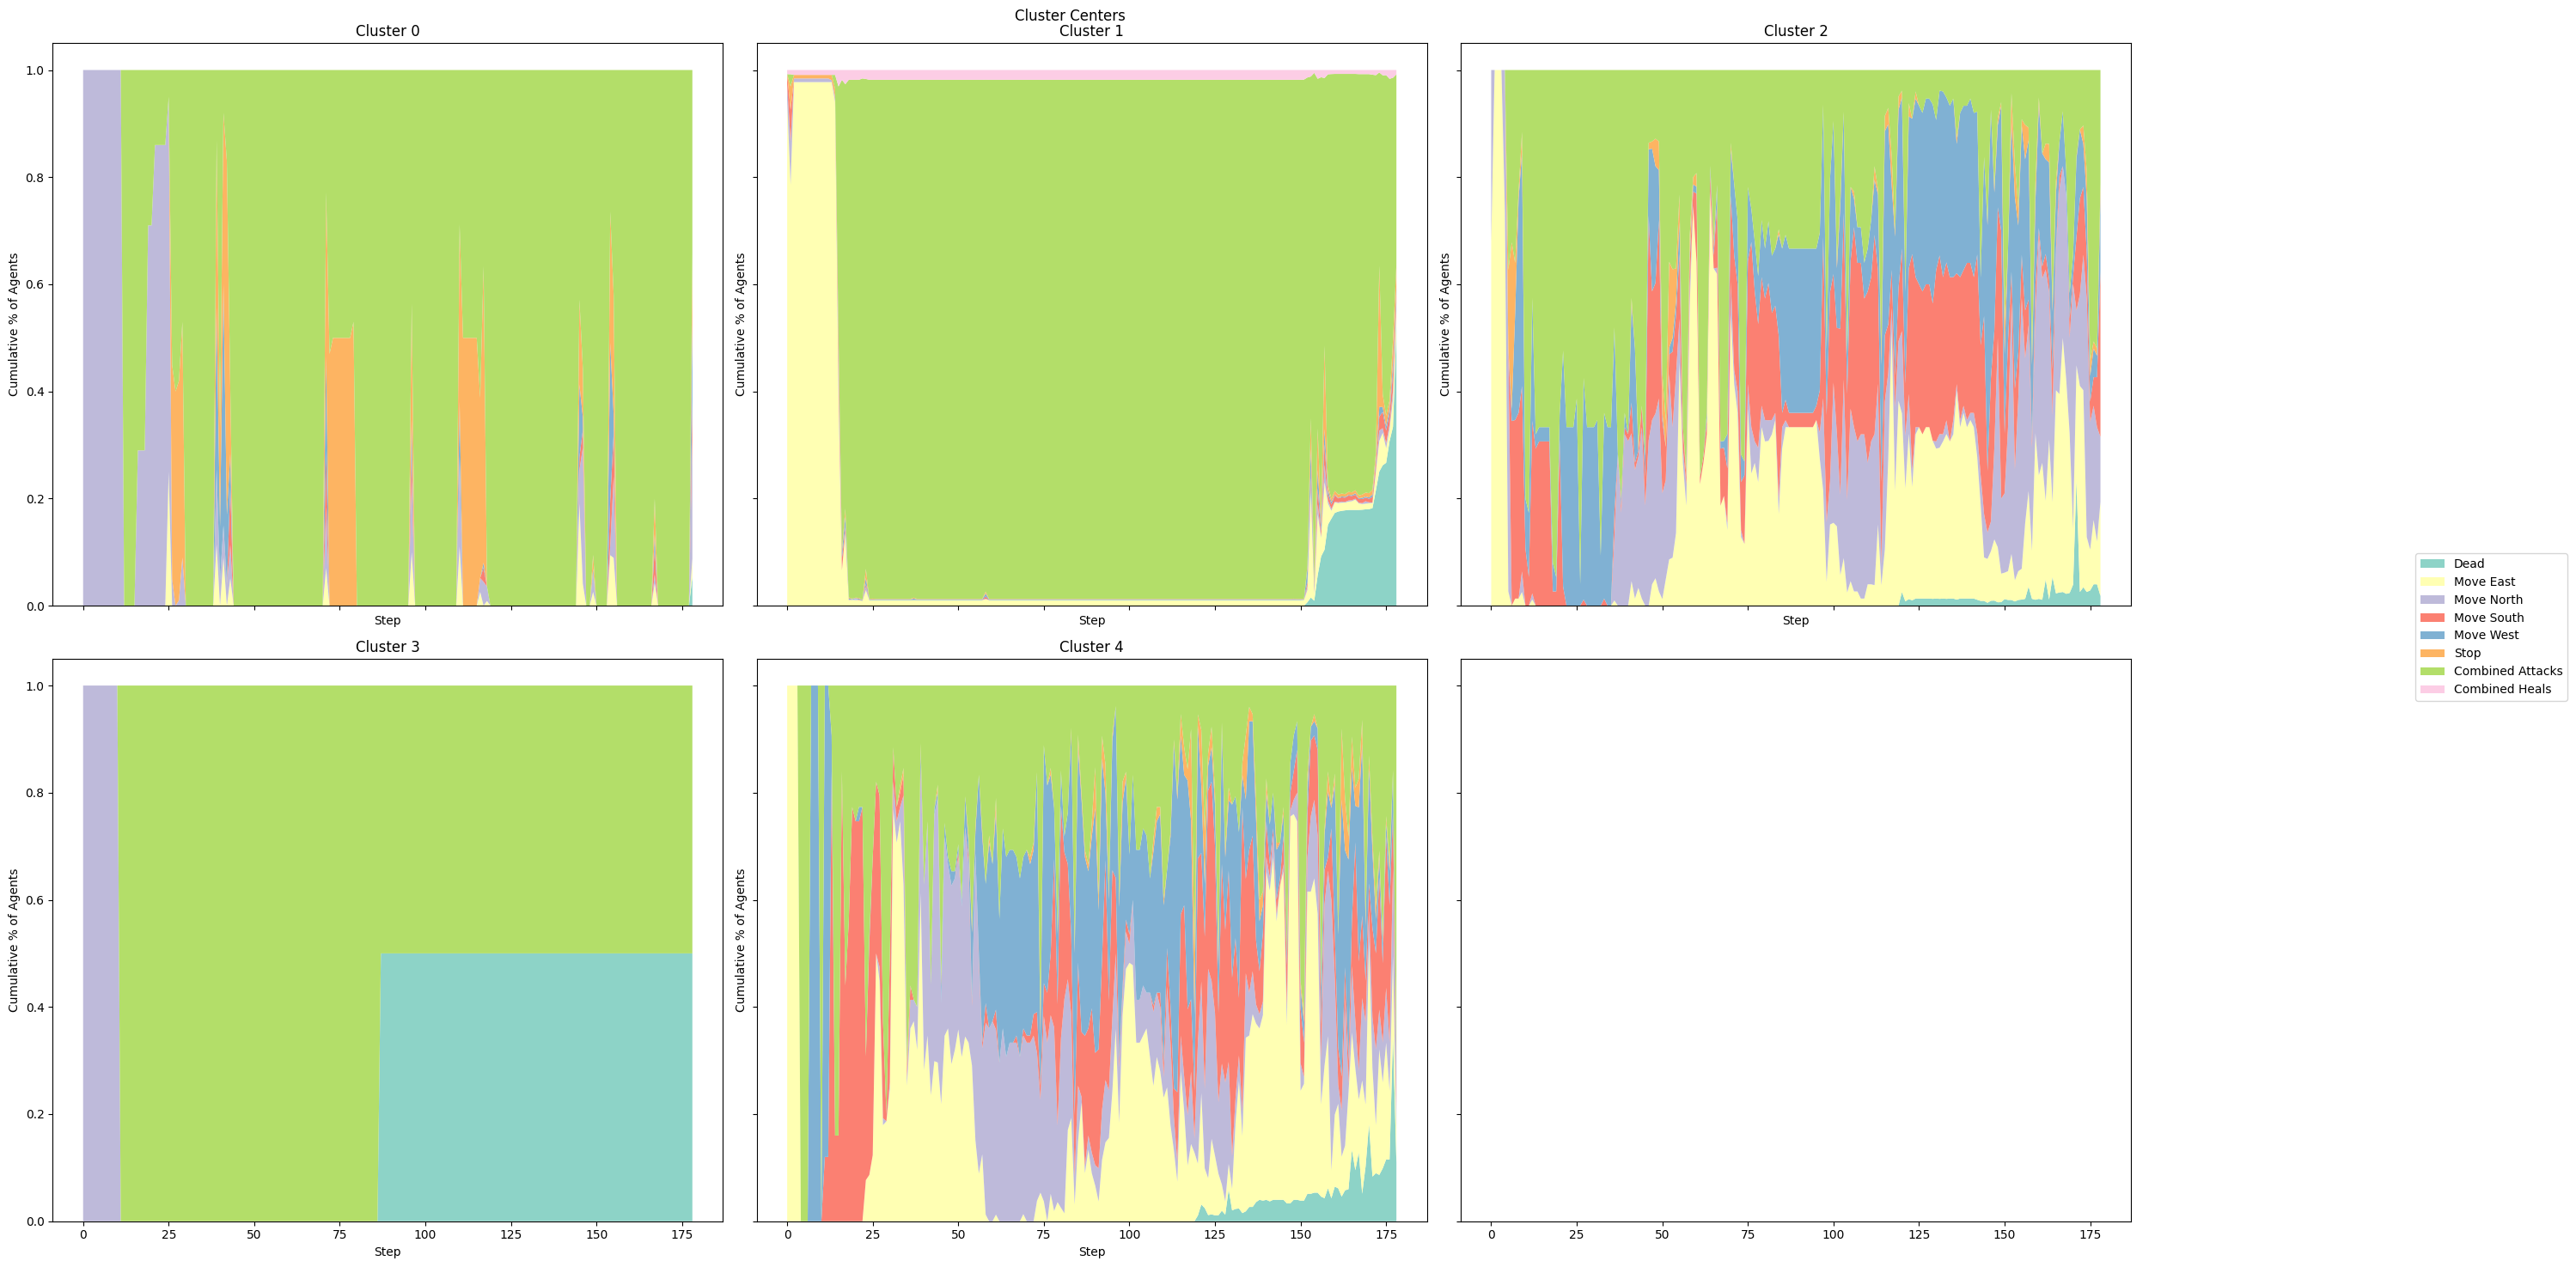

In [39]:
show_stacked_action_graph(km_clusters.cluster_centers_, 2, 3, cols, "all_clusters_stacked_actions.png")

### Hierarchical Clustering

In [28]:
import numpy as np
from tslearn.metrics import dtw
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

#Measure the DTW distance between each two trajectories
distances = np.zeros((len(all_dfs), len(all_dfs)))
for i in range(len(all_dfs)):
    for j in range(i+1, len(all_dfs)):
        distance = 0
        for feature in range(all_dfs.shape[2]):
            series1 = all_dfs[i, :, feature]
            series2 = all_dfs[j, :, feature]
            distance += dtw(series1, series2)
        distances[i, j] = distance

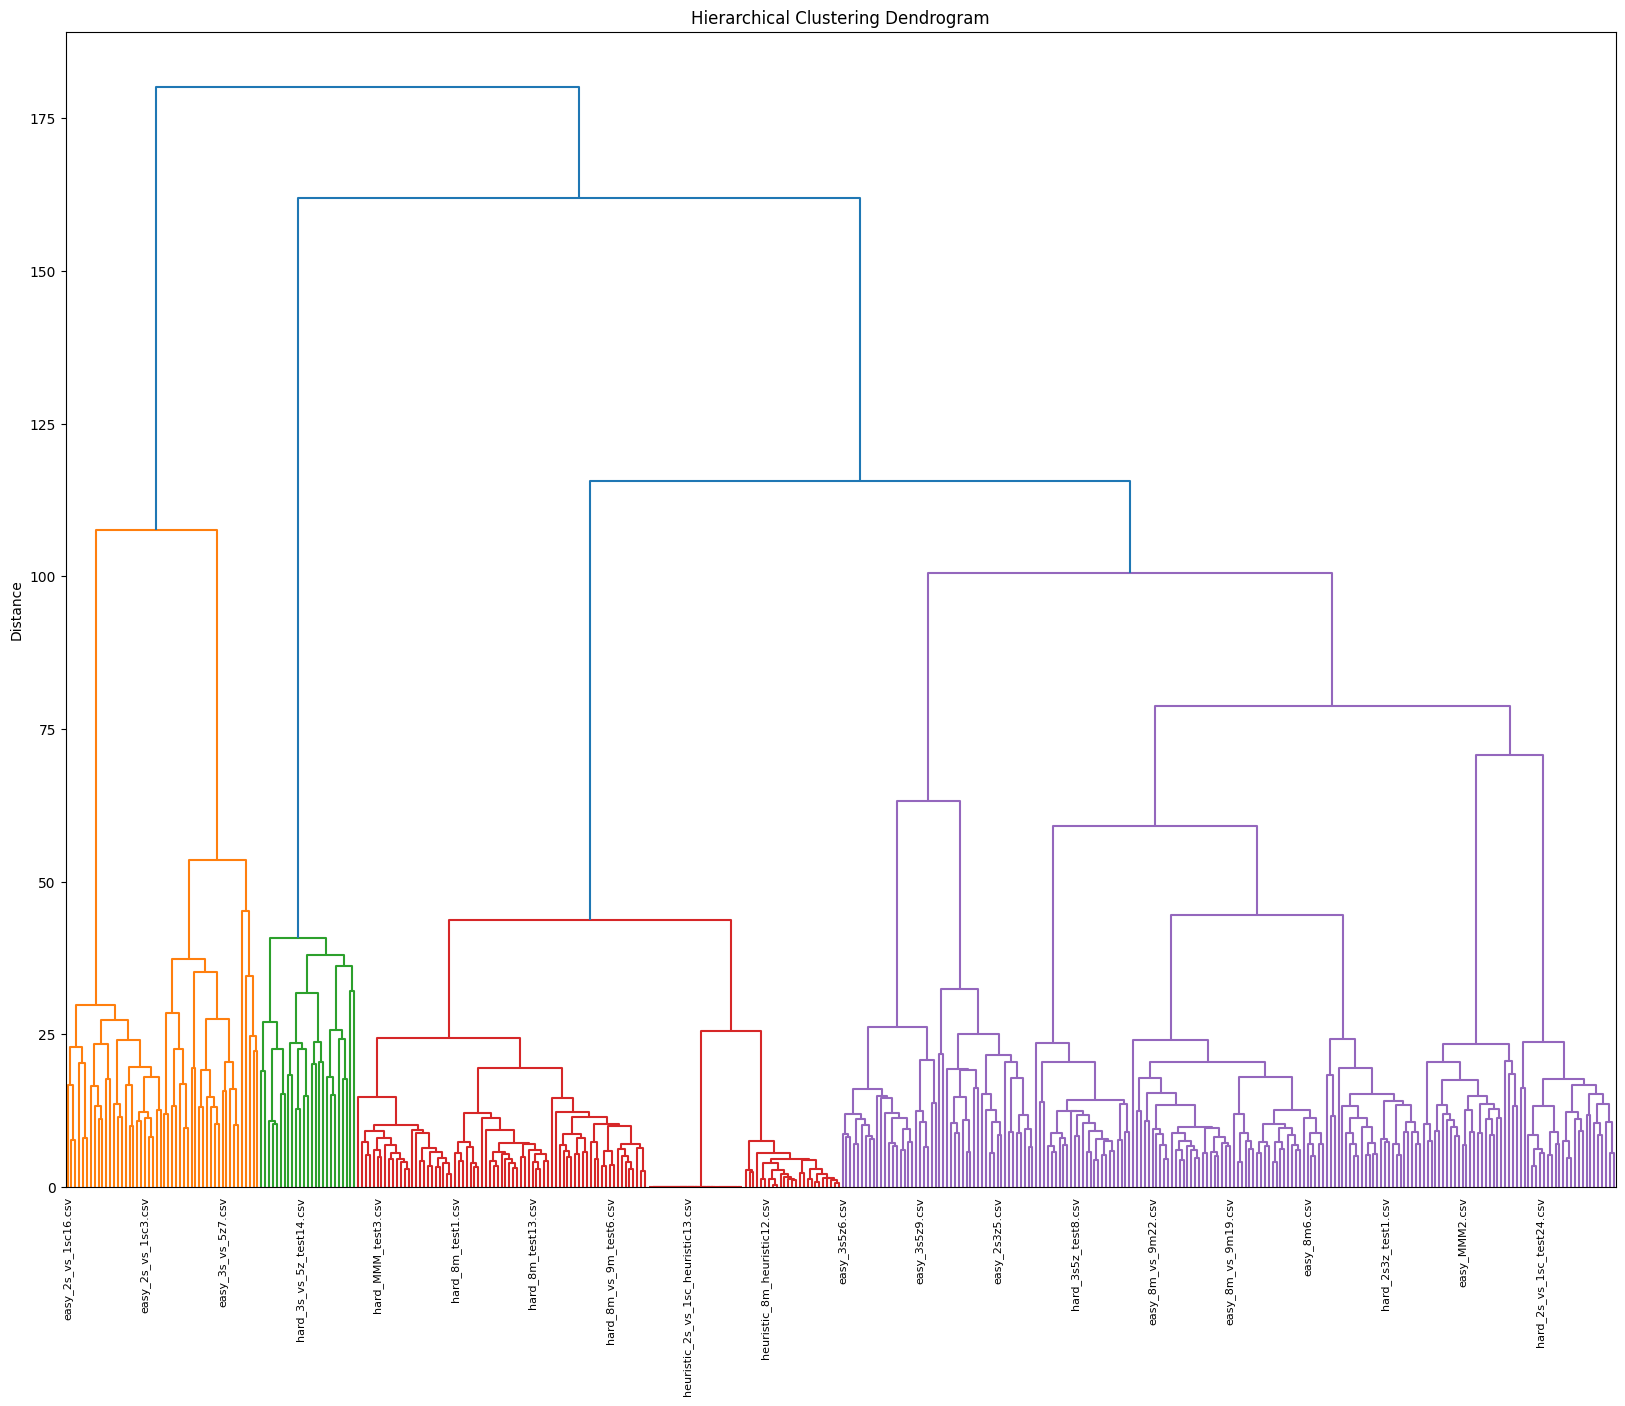

In [29]:

# Create linkage matrix
linkage_matrix = linkage(distances, method='average')

plt.figure(figsize=(20, 15))  # Adjust the figure size as desired

dendrogram(linkage_matrix, labels=file_list, leaf_font_size=8, show_contracted=True, color_threshold=110)
plt.tick_params(axis='x', labelsize=8)  # Adjust the font size as desired

plt.locator_params(axis='x', nbins=20)


plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.savefig("Hierarchical_Clustering_Dendrogram.png")
plt.show()

In [30]:
# Assignment to clusters according to hierarchical clustering:

from scipy.cluster.hierarchy import fcluster

threshold = 110  # Adjust the threshold based on the dendrogram plot and your desired number of clusters
cluster_labels = fcluster(linkage_matrix, threshold, criterion='distance')

# Print file names with their corresponding cluster assignments
clusters = []
for i, file_name in enumerate(all_dfs):
    clusters.append(cluster_labels[i])

# Create a df from file_list and clusters
df = pd.DataFrame(list(zip(file_list, clusters)), columns=["File Name", "Cluster"])
df.to_csv("ClusterAssignments_110.csv", index=False)

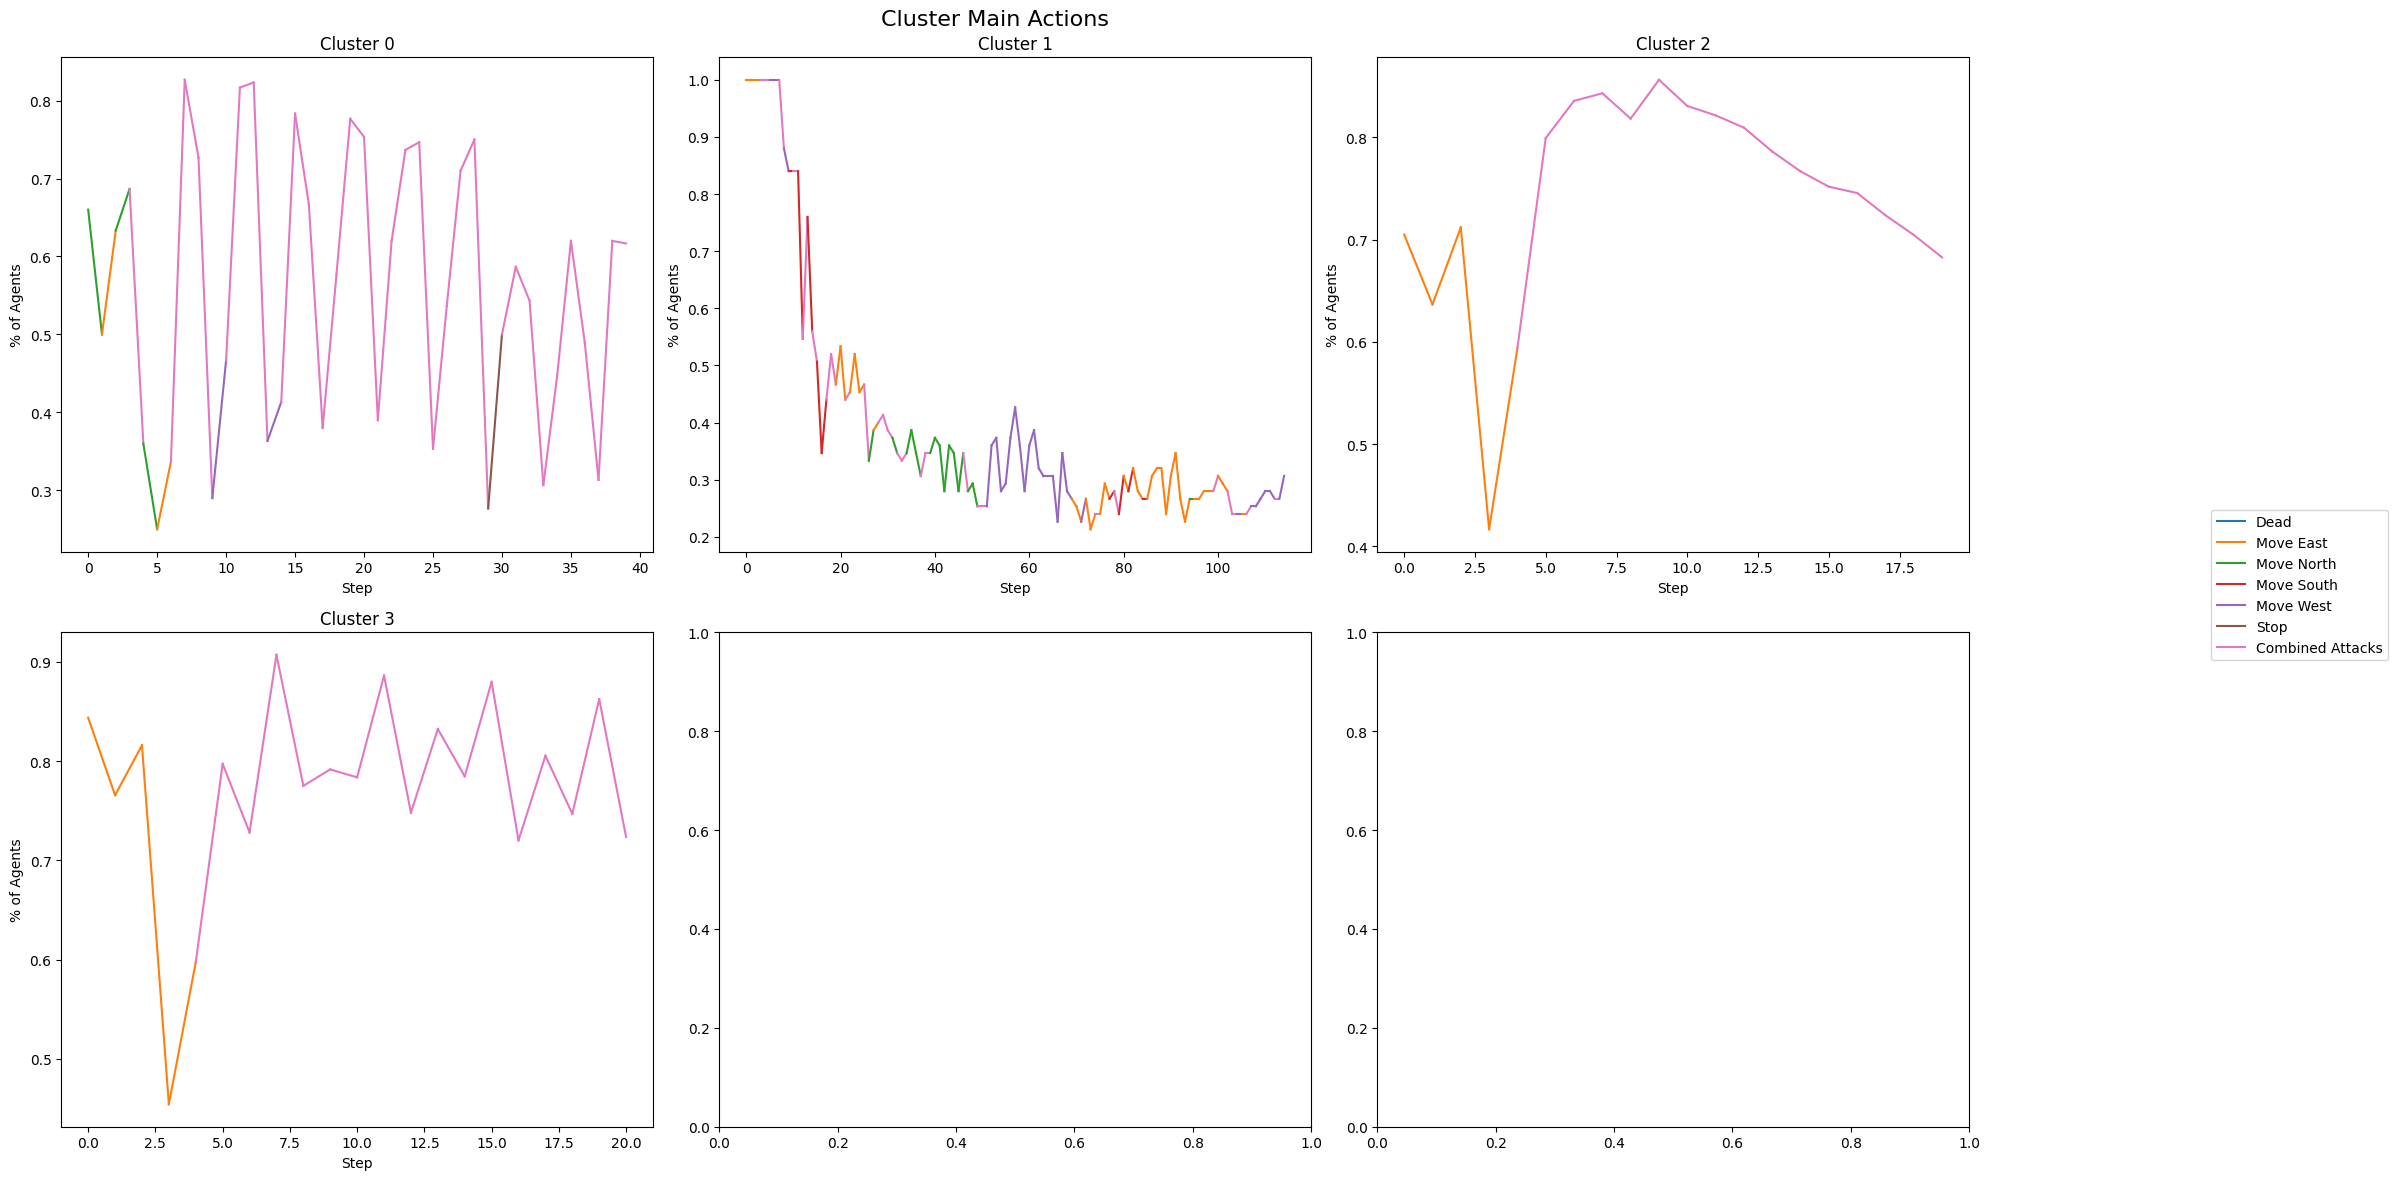

In [40]:
import numpy as np

# Perform hierarchical clustering and obtain the linkage_matrix
# ...

# Determine cluster assignments
threshold = 110
cluster_labels = fcluster(linkage_matrix, threshold, criterion='distance')

# Compute cluster centers
cluster_centers = []
for cluster in np.unique(cluster_labels):
    indices = np.where(cluster_labels == cluster)[0]
    cluster_data = all_dfs[indices]
    cluster_center = np.mean(cluster_data, axis=0)
    cluster_centers.append(cluster_center)

show_main_action_graph(cluster_centers, 2, 3, cols, "hierarchical_cluster_centers.png")
